/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


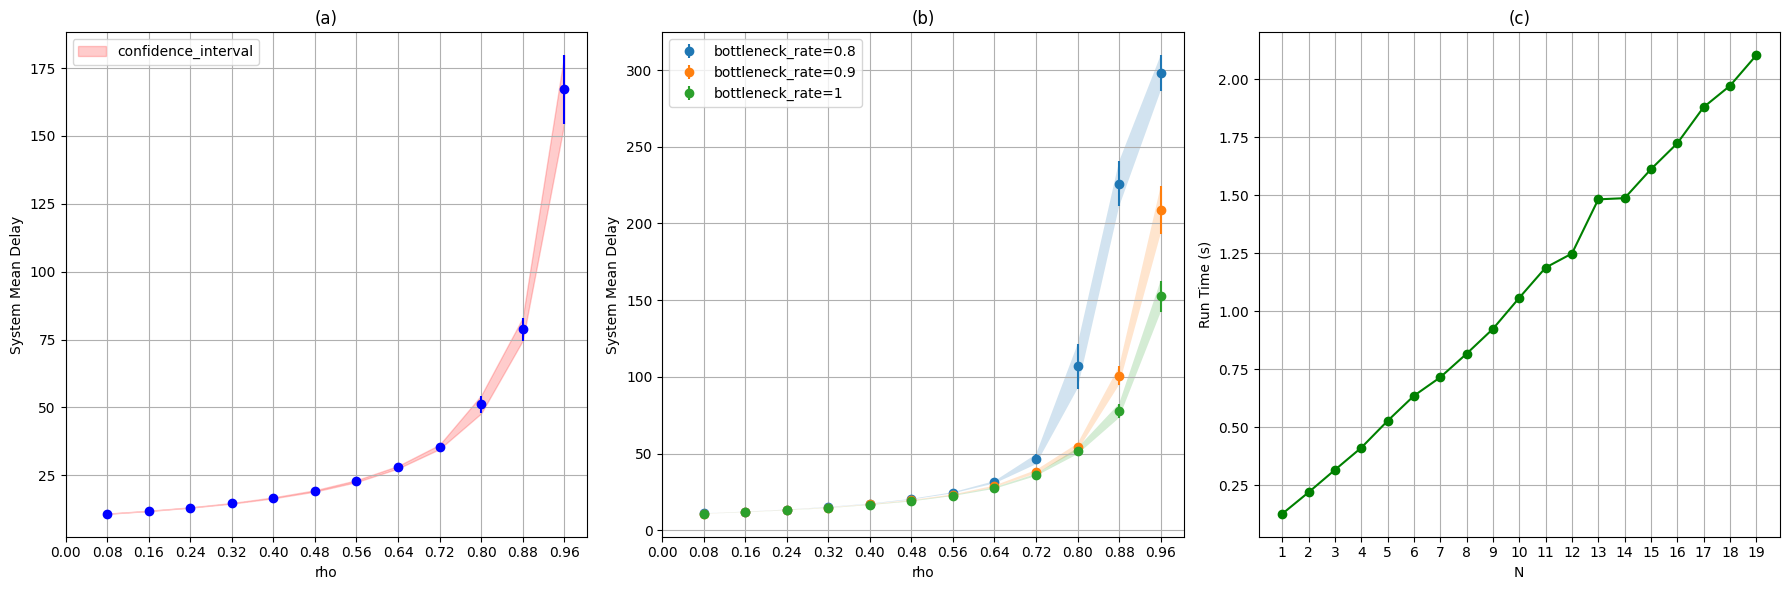

In [1]:
import heapq
import random
random.seed(1234)
import numpy as np
import matplotlib.pyplot as plt

N = 10
# a_rate = 1.0
s_rate = 1

def simulate_tandem_queues(N, a_rate, s_rate, bottleneck_rate):
    mean_delays = []
    means_cust = []

    for i in range(30):
        clock = 0
        next_arrival = random.expovariate(a_rate)
        queues = [[] for _ in range(N)]
        customers_in_queues = [0] * N
        total_delay = 0
        total_customers = 0
        queue_snapshots = [[] for _ in range(N)]

        next_departures = [float('inf')] * N

        arrival_times = {} 

        while total_customers < 3000:
            next_event_time = min(next_arrival, min(next_departures))
            next_event_queue = 0 if next_event_time == next_arrival else next_departures.index(next_event_time) + 1

            if next_event_queue == 0:
                clock = next_arrival
                total_customers += 1
                customers_in_queues[0] += 1
                heapq.heappush(queues[0], (clock, total_customers))
                arrival_times[total_customers] = clock  # Record arrival time of the customer
                next_arrival += random.expovariate(a_rate)
                if customers_in_queues[0] == 1:
                    service_time = random.expovariate(s_rate)
                    next_departures[0] = queues[0][-1][0] + service_time
            else:
                queue_index = next_event_queue - 1
                clock = next_departures[queue_index]
                _, customer_id = heapq.heappop(queues[queue_index])
                if queue_index == N - 1:  # Last queue
                    if total_customers > 800:
                        total_delay += clock - arrival_times[customer_id]  # Total delay from first to last queue
                # if total_customers > 800:
                #     queue_snapshots[queue_index].append(len(queues[queue_index]))
                customers_in_queues[queue_index] -= 1
                if customers_in_queues[queue_index] == 0:
                    next_departures[queue_index] = float('inf')
                else:
                    if queue_index==(N//2):
                        service_time = random.expovariate(bottleneck_rate) ##### vary to observe effect of bottleneck queue
                    else:
                        service_time = random.expovariate(s_rate)
                    next_departures[queue_index] = clock + service_time
                if queue_index < N - 1:
                    customers_in_queues[queue_index + 1] += 1
                    heapq.heappush(queues[queue_index + 1], (clock, customer_id))
                    if customers_in_queues[queue_index + 1] == 1:
                        if (queue_index+1)==(N//2):
                            service_time = random.expovariate(bottleneck_rate) ##### vary to observe effect of bottleneck queue
                        else:
                            service_time = random.expovariate(s_rate)
                        next_departures[queue_index + 1] = queues[queue_index + 1][-1][0] + service_time

        means_cust.append([np.mean(snapshot) for snapshot in queue_snapshots])
        here_mean_delay = total_delay / (total_customers - 800)
        mean_delays.append(here_mean_delay)
    return mean_delays, means_cust
# Set up the plots
fig, axs = plt.subplots(1, 3,figsize=(18,6))

# Plotting the first graph
means_delay = []
confidence_intervals_delay = []
for i in range(1, 13):
    mean_delay, _ = simulate_tandem_queues(N, i * 0.08, s_rate, 1)
    means_delay.append(np.mean(mean_delay))

    n_delay = len(mean_delay)
    std_dev_delay = np.std(mean_delay)
    z_delay = 1.96
    margin_of_error_delay = z_delay * (std_dev_delay / np.sqrt(n_delay))
    confidence_intervals_delay.append(margin_of_error_delay)

axs[0].errorbar(np.arange(1, 13) * 0.08, means_delay, yerr=confidence_intervals_delay, fmt='o', color='b')
axs[0].fill_between(np.arange(1, 13) * 0.08, np.array(means_delay) - np.array(confidence_intervals_delay), np.array(means_delay) + np.array(confidence_intervals_delay),label="confidence_interval", color='r', alpha=0.2)
axs[0].set_xlabel('rho')
axs[0].set_ylabel('System Mean Delay')
axs[0].set_title('(a)')
axs[0].grid(True)
axs[0].legend(loc='upper left')
axs[0].set_xticks(np.arange(0, 1, step=0.08))  

# Plotting the second graph
bottleneck_rates = [0.8, 0.9, 1]
for bottleneck_rate in bottleneck_rates:
    means_delay = []
    confidence_intervals_delay = []
    for i in range(1, 13):
        mean_delay, _ = simulate_tandem_queues(N, i * 0.08, s_rate, bottleneck_rate)
        means_delay.append(np.mean(mean_delay))

        n_delay = len(mean_delay)
        std_dev_delay = np.std(mean_delay)
        z_delay = 1.96
        margin_of_error_delay = z_delay * (std_dev_delay / np.sqrt(n_delay))
        confidence_intervals_delay.append(margin_of_error_delay)

    axs[1].errorbar(np.arange(1, 13) * 0.08, means_delay, yerr=confidence_intervals_delay, fmt='o', label=f'bottleneck_rate={bottleneck_rate}')
    axs[1].fill_between(np.arange(1, 13) * 0.08, np.array(means_delay) - np.array(confidence_intervals_delay), np.array(means_delay) + np.array(confidence_intervals_delay), alpha=0.2)

axs[1].set_xlabel('rho')
axs[1].set_ylabel('System Mean Delay')
axs[1].set_title('(b)')
axs[1].grid(True)
axs[1].legend(loc='upper left')
axs[1].set_xticks(np.arange(0, 1, step=0.08))

import time

def measure_runtime(N, a_rate, s_rate):
    start_time = time.time()
    simulate_tandem_queues(N, a_rate, s_rate, s_rate)
    end_time = time.time()
    return end_time - start_time

# Plotting the third graph
N_values = list(range(1, 20))
runtimes = [measure_runtime(N, 0.5, 1.0) for N in N_values]

axs[2].plot(N_values, runtimes, marker='o', color='g')
axs[2].set_xlabel('N')
axs[2].set_ylabel('Run Time (s)')
axs[2].set_title('(c)')
axs[2].grid(True)
axs[2].set_xticks(N_values)

plt.tight_layout()
plt.savefig("q1.pdf")
plt.show()